# Heat Equation Epidemiology - California Cities

## Introduction
This notebook demonstrates how to use the heat equation (a partial differential equation) to model the spread of an infection across cities in California. We'll visualize the spread using heatmaps overlaid on a map of California and track metrics like time to reach various infection thresholds.

## Setup and Imports

<div style="margin: 20px 25px 20px">

# How to Download and Use County Shapefiles for the California Infection Model
<div style="margin: 20px 25px 20px">

The improved heat equation model uses county boundaries as potential barriers for infection spread. Here's how to obtain and use the necessary county shapefile data:

## Manual Download
<div style="margin: 20px 25px 20px">

If you prefer to download the county shapefile manually:
<div style="margin: 20px 25px 20px">

1. Visit the US Census Bureau's TIGER/Line Shapefiles website: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html
2. Navigate to the most recent year's data
3. Select "Counties (and equivalent)" under the "Nation-based" files
4. Download the ZIP file containing the county boundaries
5. Extract the contents to a directory of your choice
6. Pass the path to the .shp file when creating the model:

</div>

```python
# Create model with manually downloaded shapefile
model = CaliforniaInfectionModel(
    use_county_boundaries=True,
    county_shapefile="/path/to/your/tl_YYYY_us_county.shp"
)
```
</div>

## Requirements
<div style="margin: 20px 25px 20px">

To use county boundaries in the model, you'll need:
<div style="margin: 20px 25px 20px">

- **GeoPandas** package: `pip install geopandas`
- **Shapely** package: `pip install shapely`
- **Cartopy** package: `pip install cartopy`

</div>

If you encounter installation issues with these packages, consider using conda:


```bash
conda install -c conda-forge geopandas shapely cartopy
```
</div>

## Using County Boundaries as Barriers
<div style="margin: 20px 25px 20px">

County boundaries are used as partial barriers to infection spread in the model. The diffusion coefficient is reduced at county borders, simulating reduced travel between counties. You can control this feature with the `use_county_boundaries` parameter:



```python
# Run with county boundaries as barriers
model = CaliforniaInfectionModel(use_county_boundaries=True)

# Run without county boundaries as barriers
model = CaliforniaInfectionModel(use_county_boundaries=False)
```

The model also prevents infection from spreading into the ocean by applying a coastline mask and land mask to the infection grid.

</div>

</div>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.animation import FuncAnimation

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.widgets import Slider, Button

import os
import time

import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
import requests
import zipfile
import io
from IPython.display import HTML, display
from mpl_toolkits.mplot3d import Axes3D

# Create output directory
#os.makedirs('results', exist_ok=True)

## Define California Cities
We'll start by defining the major cities in California with their coordinates and populations.


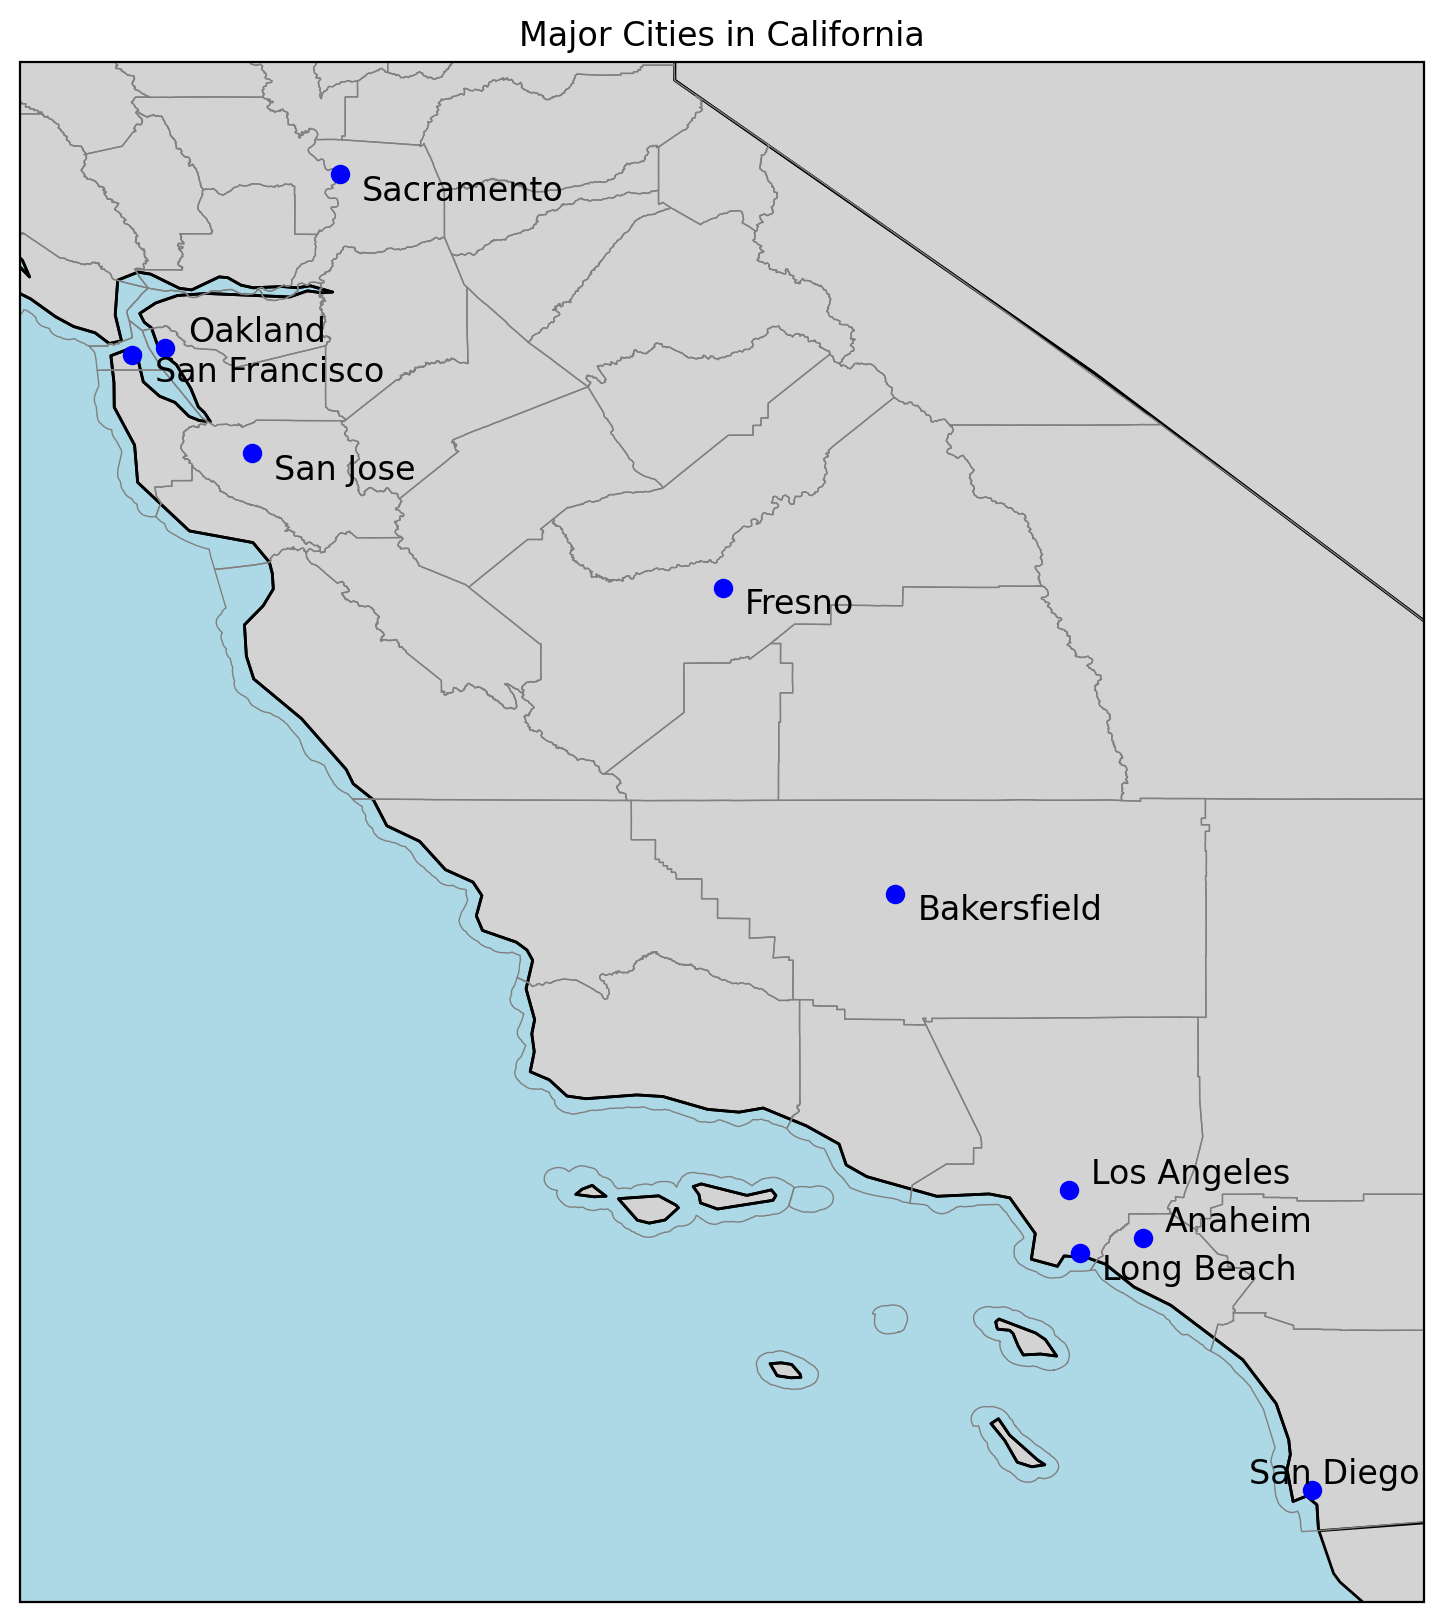

In [5]:
# Configure matplotlib for better visualizations
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['figure.dpi'] = 200

# Define major California cities with their coordinates and populations
california_cities = {
    "Los Angeles": {"lat": 34.0522, "lon": -118.2437, "population": 3980000},
    "San Diego": {"lat": 32.7157, "lon": -117.1611, "population": 1410000},
    "San Jose": {"lat": 37.3382, "lon": -121.8863, "population": 1030000},
    "San Francisco": {"lat": 37.7749, "lon": -122.4194, "population": 875000},
    "Fresno": {"lat": 36.7378, "lon": -119.7871, "population": 530000},
    "Sacramento": {"lat": 38.5816, "lon": -121.4944, "population": 510000},
    "Long Beach": {"lat": 33.7701, "lon": -118.1937, "population": 466000},
    "Oakland": {"lat": 37.8044, "lon": -122.2711, "population": 433000},
    "Bakersfield": {"lat": 35.3733, "lon": -119.0187, "population": 380000},
    "Anaheim": {"lat": 33.8366, "lon": -117.9143, "population": 350000}
}

# Calculate the bounding box for California
lats = [city["lat"] for city in california_cities.values()]
lons = [city["lon"] for city in california_cities.values()]
min_lat, max_lat = min(lats) - 0.5, max(lats) + 0.5
min_lon, max_lon = min(lons) - 0.5, max(lons) + 0.5

counties = gpd.read_file('/Users/matt/Documents/MT Data Projects/Epid/CountyLines/tl_2023_us_county.shp')
california_counties = counties[counties['STATEFP'] == '06']


# Quick visualization of the cities
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add land and ocean background
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='lightgray')
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='lightblue')

# Add coastlines and state boundaries
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black')

# Add California county boundaries
for geometry in california_counties.geometry:
    ax.add_geometries([geometry], crs=ccrs.PlateCarree(),
                      edgecolor='gray', facecolor='none', linewidth=0.5)

for city, data in california_cities.items():
    if city in ['Oakland','Anaheim','Los Angeles']:
        plt.plot(data["lon"], data["lat"], 'bo', markersize=6)
        plt.text(data["lon"] + 0.1, data["lat"], city, fontsize=12, va='bottom',ha='left')
    elif city in ['San Diego']:
        plt.plot(data["lon"], data["lat"], 'bo', markersize=6)
        plt.text(data["lon"] + 0.1, data["lat"], city, fontsize=12, va='bottom',ha='center')
    else:
        plt.plot(data["lon"], data["lat"], 'bo', markersize=6)
        plt.text(data["lon"] + 0.1, data["lat"], city, fontsize=12, va='top',ha='left')


# Set extent to focus on California
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

plt.xlim(min_lon, max_lon)
plt.ylim(min_lat, max_lat)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Major Cities in California')
plt.grid(True)
plt.show()

## Creating Boundary Masks
### Now we'll create masks for county boundaries and coastlines to control infection spread:


Creating boundary masks...
Creating county boundary mask...
Boundary masks created


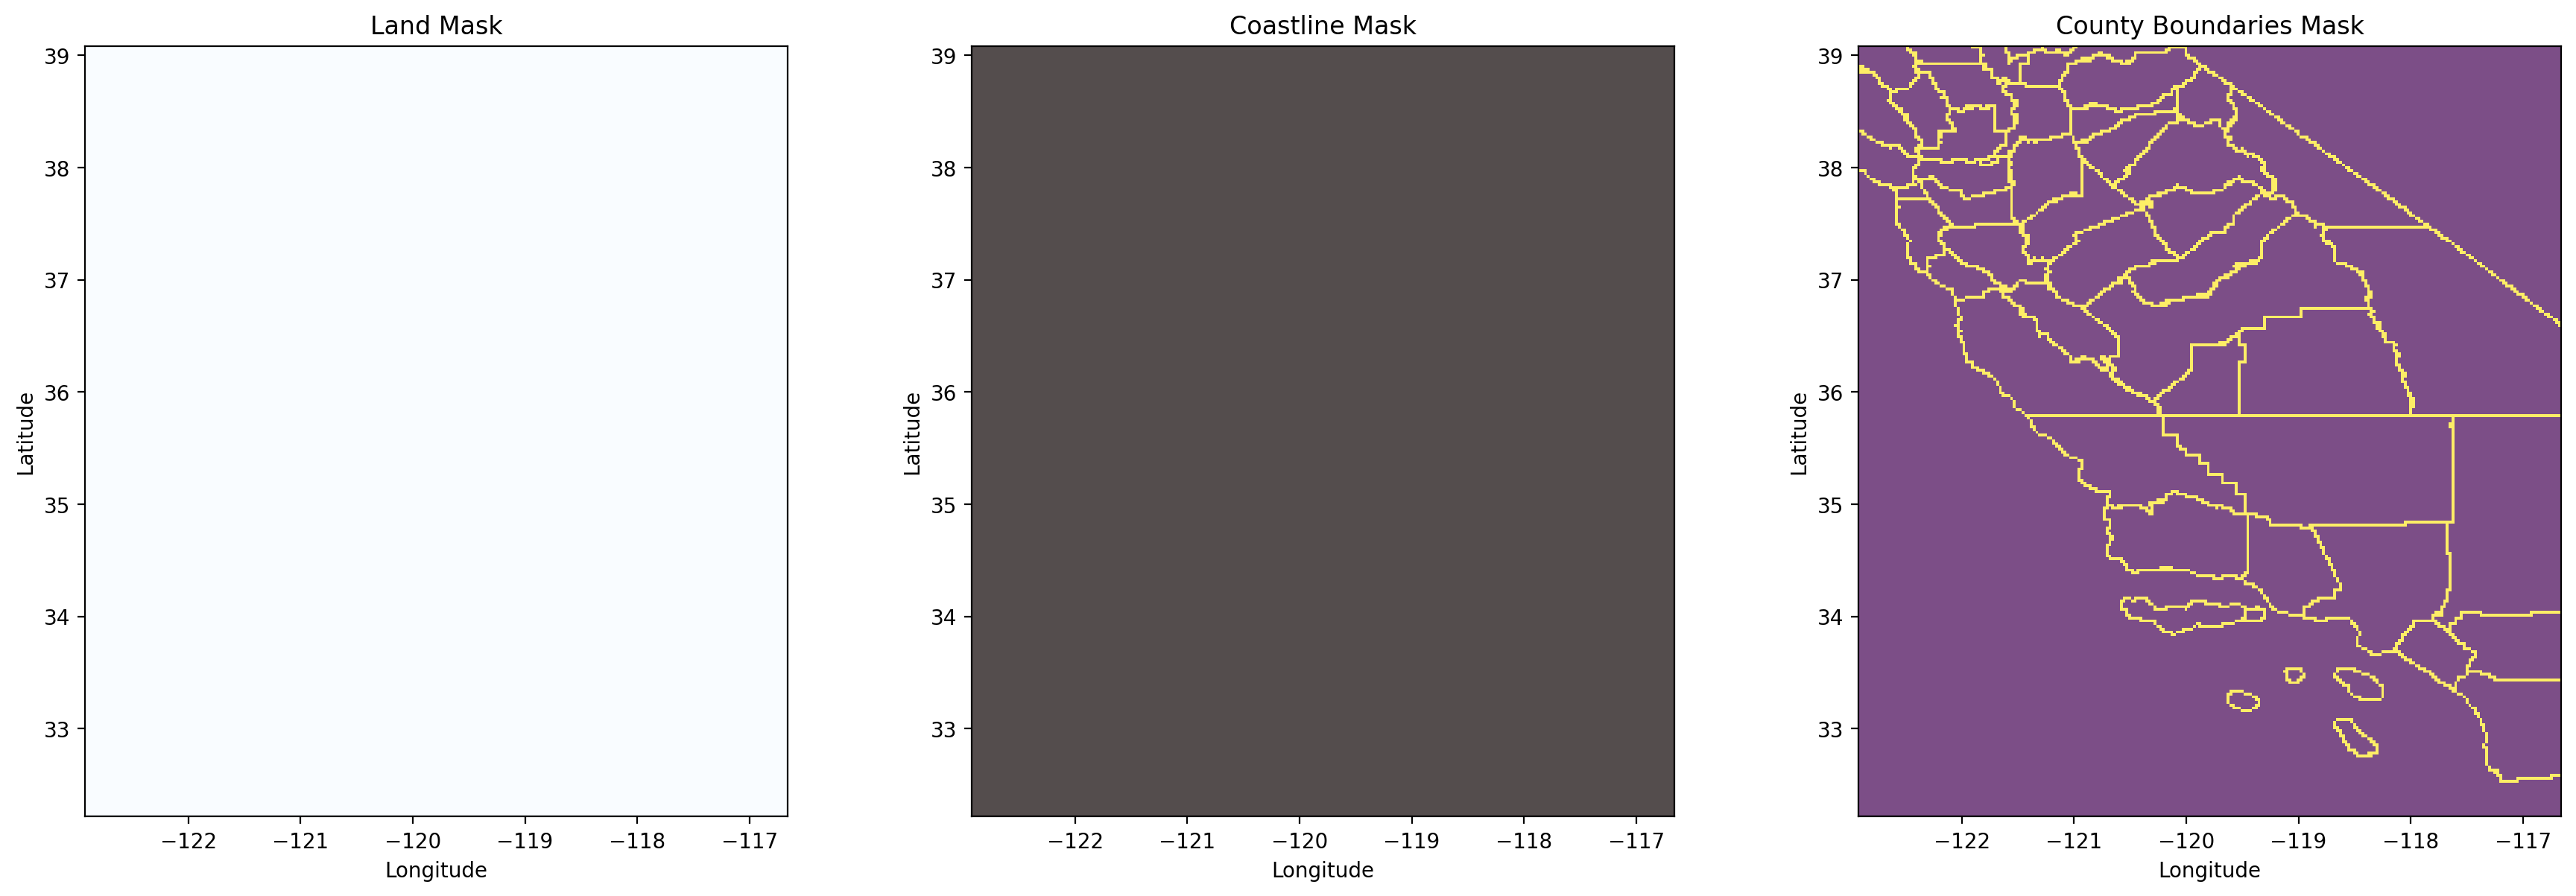

In [6]:
def create_boundary_masks(grid_height, grid_width, min_lat, max_lat, min_lon, max_lon, counties=None):
    from shapely.geometry import Point
    from shapely.strtree import STRtree
    import numpy as np

    print("Creating boundary masks...")
    
    # Initialize masks
    county_boundaries_mask = np.zeros((grid_height, grid_width), dtype=bool)
    coastline_mask = np.zeros((grid_height, grid_width), dtype=bool)
    
    # Grid
    x = np.linspace(min_lon, max_lon, grid_width)
    y = np.linspace(min_lat, max_lat, grid_height)
    X, Y = np.meshgrid(x, y)
    
    # Quick ocean mask based on rough bounds (simple version)
    #land_mask[(X < -124.3) | ((X < -121.8) & (Y < 36.5)) | ((X < -118.0) & (Y < 33.0))] = False
    land_mask = np.ones((grid_height, grid_width), dtype=bool)
    
    # Find coastline by detecting edges between land and ocean
    coastline_mask = np.zeros_like(land_mask)
    coastline_mask[1:-1, 1:-1] = (
        land_mask[1:-1, 1:-1] &
        (~(land_mask[:-2, 1:-1] & land_mask[2:, 1:-1] &
           land_mask[1:-1, :-2] & land_mask[1:-1, 2:]))
    )
    
    # Create county boundary mask
    if counties is not None:
        print("Creating county boundary mask...")
        
        # Rasterize county boundaries
        from rasterio import features
        from affine import Affine

        transform = Affine(
            (max_lon - min_lon) / grid_width, 0, min_lon,
            0, (max_lat - min_lat) / grid_height, min_lat
        )

        shapes = [(geom.boundary, 1) for geom in counties.geometry if geom is not None]
        boundary_raster = features.geometry_mask(
            shapes,
            out_shape=(grid_height, grid_width),
            transform=transform,
            invert=True
        )

        county_boundaries_mask |= boundary_raster
    
    print("Boundary masks created")
    return county_boundaries_mask, coastline_mask, land_mask

# Define grid parameters
grid_resolution = 40  # points per degree
grid_width = int((max_lon - min_lon) * grid_resolution)
grid_height = int((max_lat - min_lat) * grid_resolution)

# Create the boundary masks
county_boundaries_mask, coastline_mask, land_mask = create_boundary_masks(
    grid_height, grid_width, min_lat, max_lat, min_lon, max_lon, california_counties
)

# Let's visualize the masks to check them
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Create a grid for plotting
x = np.linspace(min_lon, max_lon, grid_width)
y = np.linspace(min_lat, max_lat, grid_height)
X, Y = np.meshgrid(x, y)

# Plot land mask
axs[0].imshow(land_mask, extent=[min_lon, max_lon, min_lat, max_lat], origin='lower', cmap='Blues', alpha=0.7)
axs[0].set_title('Land Mask')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')

# Plot coastline mask
axs[1].imshow(coastline_mask, extent=[min_lon, max_lon, min_lat, max_lat], origin='lower', cmap='hot', alpha=0.7)
axs[1].set_title('Coastline Mask')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')

# Plot county boundaries mask
axs[2].imshow(county_boundaries_mask, extent=[min_lon, max_lon, min_lat, max_lat], origin='lower', cmap='viridis', alpha=0.7)
axs[2].set_title('County Boundaries Mask')
axs[2].set_xlabel('Longitude')
axs[2].set_ylabel('Latitude')

plt.tight_layout()
plt.show()


## 5. Initializing Infection Grid
### Now we'll create a function to initialize the infection grid with Gaussian bumps at each city:


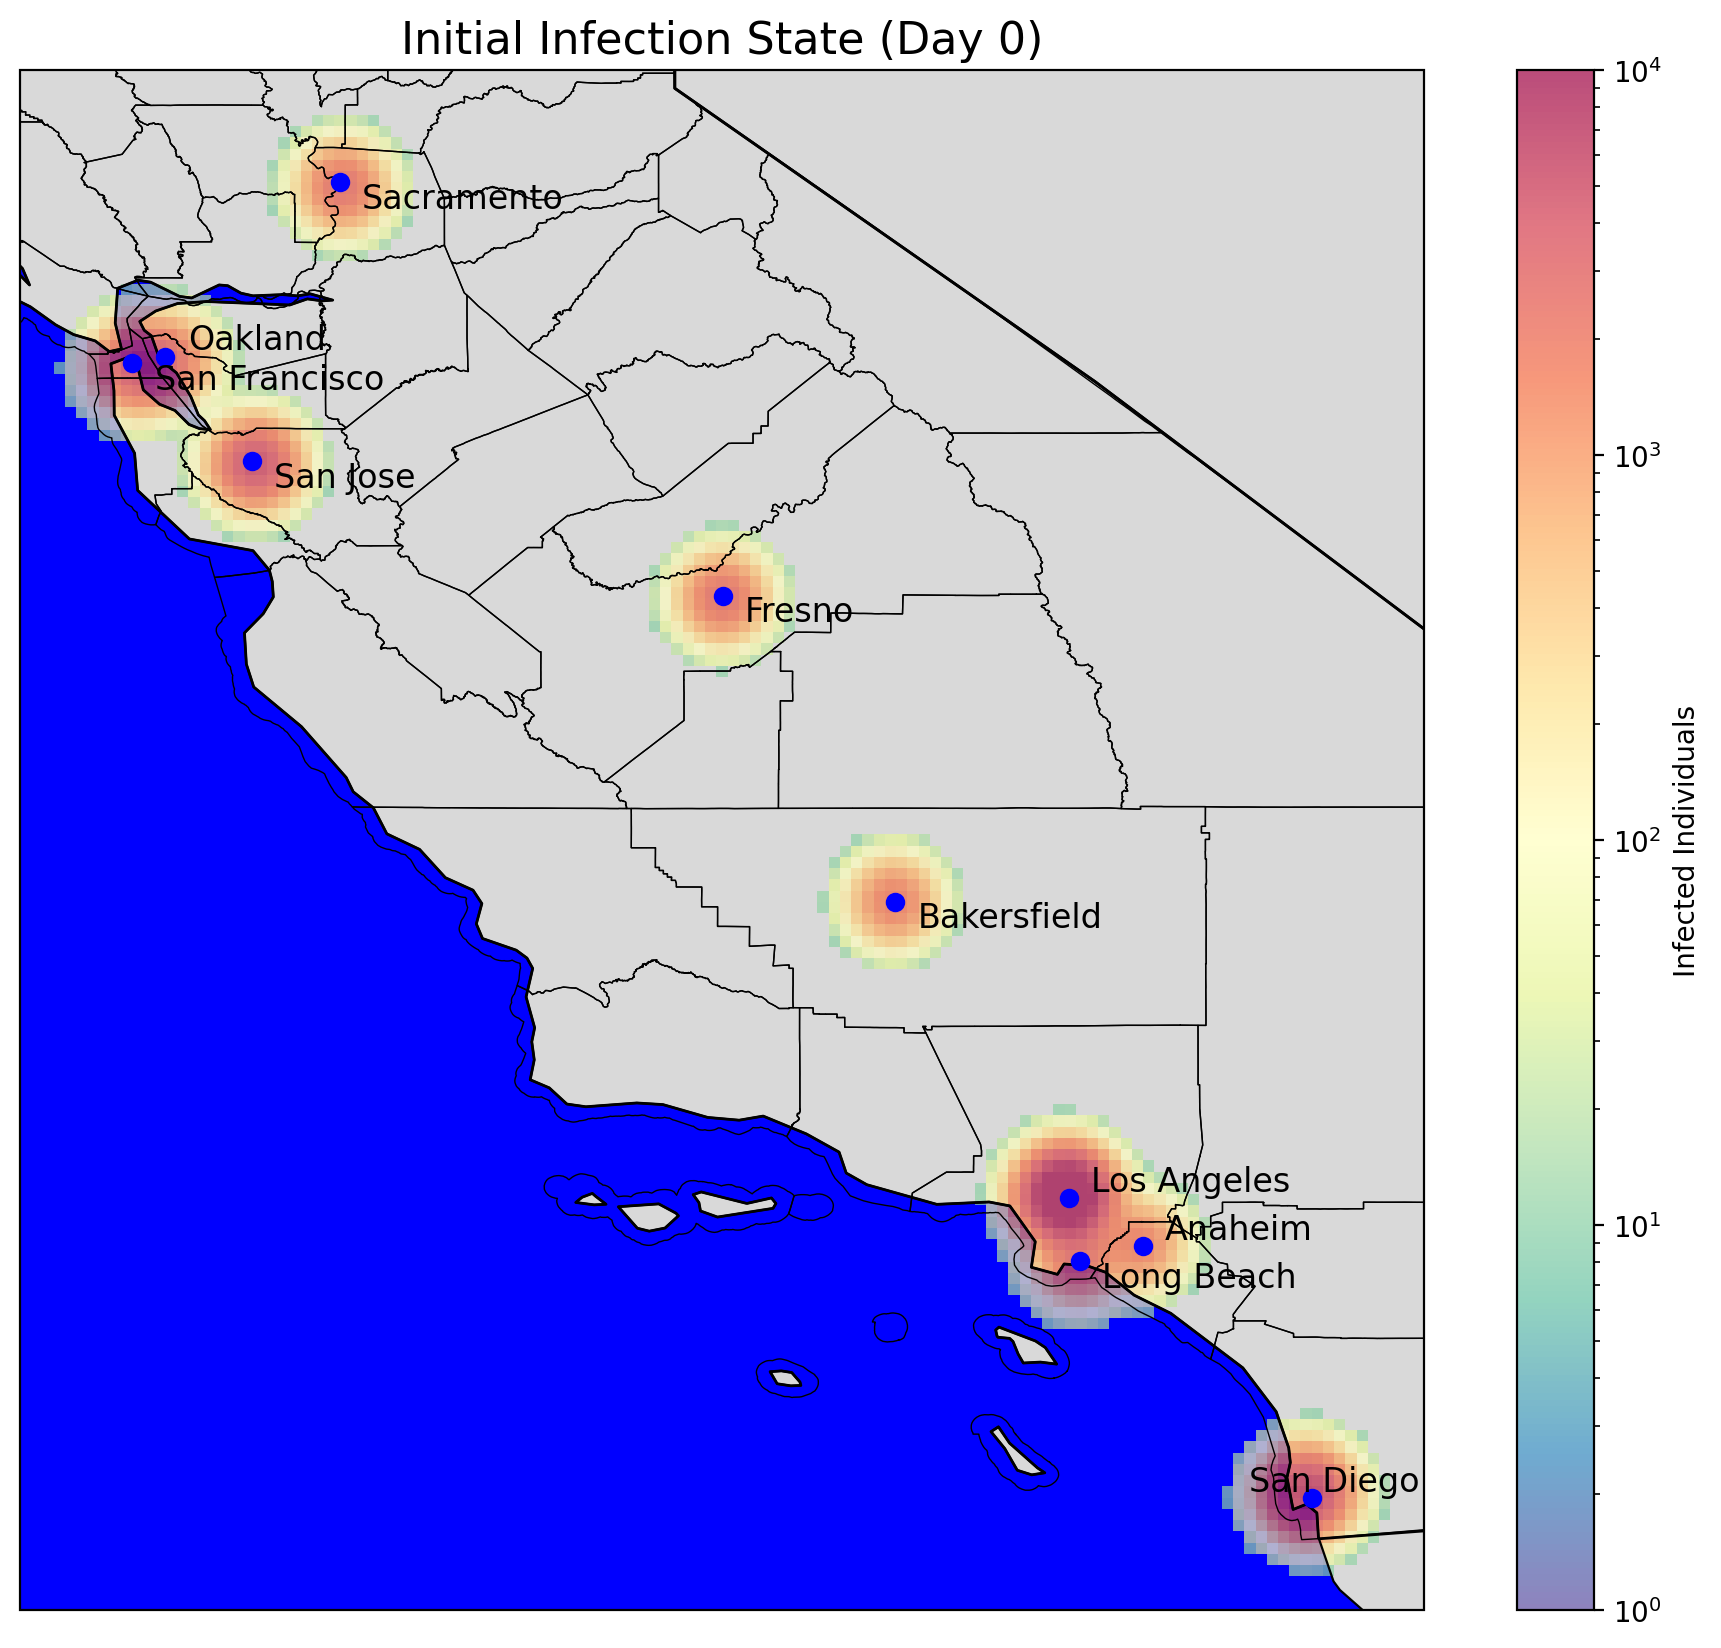

In [30]:
# ## 5. Initializing Infection Grid
# 
# Now we'll create a function to initialize the infection grid with Gaussian bumps at each city:

def initialize_infection(california_cities, min_lat, max_lat, min_lon, max_lon, 
                         grid_resolution=40, initial_infection_percentage=0.005,
                         sigma_deg=0.15, land_mask=None):
    """
    Initialize the infection grid with Gaussian bumps at each city.
    """
    # Calculate grid dimensions
    grid_width = int((max_lon - min_lon) * grid_resolution)
    grid_height = int((max_lat - min_lat) * grid_resolution)
    
    # Create empty infection grid
    u = np.zeros((grid_height, grid_width))
    
    # Create coordinate grids
    x = np.linspace(min_lon, max_lon, grid_width)
    y = np.linspace(min_lat, max_lat, grid_height)
    X, Y = np.meshgrid(x, y)
    
    # Standard deviation for the Gaussian bump in degrees
    sigma_deg = sigma_deg # ~15-20 km radius, adjustable
    
    for city, data in california_cities.items():
        # City coordinates
        lat = data["lat"]
        lon = data["lon"]
        pop = data["population"]
        
        # Infection strength based on population
        amplitude = pop * initial_infection_percentage
        
        # Gaussian bump calculation
        distance_squared = (X - lon) ** 2 + (Y - lat) ** 2
        gaussian_bump = amplitude * np.exp(-distance_squared / (2 * sigma_deg ** 2))
        
        # Add bump to the grid
        u += gaussian_bump
    
    # Apply land mask to prevent ocean leakage
    if land_mask is not None:
        u *= land_mask
    
    return u


# Initialize the infection grid
u = initialize_infection(
    california_cities, min_lat, max_lat, min_lon, max_lon,
    grid_resolution=grid_resolution, initial_infection_percentage=0.005,
    land_mask=land_mask, sigma_deg = 0.10
)
u[u < 10] = 0


# Visualize the initial infection state
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='#d9d9d9')
ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='blue')
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.8)
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black')

# Add county boundaries if available
if california_counties is not None:
    ax.add_geometries(
        california_counties.geometry,
        crs=ccrs.PlateCarree(),
        edgecolor='black',
        facecolor='none',
        linewidth=0.5
    )

# Set map extent to California
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Create a logarithmic colormap for better visualization
norm = colors.LogNorm(vmin=1, vmax=10000)

# Display initial infection state
infection_plot = ax.imshow(
    u,
    extent=[min_lon, max_lon, min_lat, max_lat],
    transform=ccrs.PlateCarree(),
    origin='lower',
    cmap='Spectral_r',
    norm=norm,
    alpha=0.7
)

# Add colorbar
plt.colorbar(infection_plot, ax=ax, label='Infected Individuals')

# Add city markers with improved positioning
for city, data in california_cities.items():
    if city in ['Oakland', 'Anaheim', 'Los Angeles']:
        ax.plot(data["lon"], data["lat"], 'bo', markersize=6, transform=ccrs.PlateCarree())
        ax.text(data["lon"] + 0.1, data["lat"], city, fontsize=12, va='bottom', ha='left',
               transform=ccrs.PlateCarree())
    elif city in ['San Diego']:
        ax.plot(data["lon"], data["lat"], 'bo', markersize=6, transform=ccrs.PlateCarree())
        ax.text(data["lon"] + 0.1, data["lat"], city, fontsize=12, va='bottom', ha='center',
               transform=ccrs.PlateCarree())
    else:
        ax.plot(data["lon"], data["lat"], 'bo', markersize=6, transform=ccrs.PlateCarree())
        ax.text(data["lon"] + 0.1, data["lat"], city, fontsize=12, va='top', ha='left',
               transform=ccrs.PlateCarree())

plt.title('Initial Infection State (Day 0)', fontsize=16)
plt.show()

In [31]:
def solve_heat_equation_step(u, diffusion_coefficient=0.1, dt=0.01, 
                            coastline_mask=None, land_mask=None):
    """Solve one step of the heat equation using finite differences"""
    # Create a copy to avoid modifying while updating
    u_new = u.copy()
    
    # Apply boundary conditions (Dirichlet: zero at boundaries)
    u_new[0, :] = 0
    u_new[-1, :] = 0
    u_new[:, 0] = 0
    u_new[:, -1] = 0
    
    # Calculate the Laplacian
    laplacian = (
        u_new[:-2, 1:-1] +
        u_new[2:, 1:-1] +
        u_new[1:-1, :-2] +
        u_new[1:-1, 2:] -
        4 * u_new[1:-1, 1:-1]
    )
    
    # Update the interior points
    u_new[1:-1, 1:-1] += diffusion_coefficient * dt * laplacian
    
    # 🛠 ONLY slow down near the coastlines
    if coastline_mask is not None:
        u_new[coastline_mask] *= 0.05  # Strong diffusion suppression at ocean edges
    
    # 🛠 Hard zero out infection into ocean
    if land_mask is not None:
        u_new = u_new * land_mask
    
    # Ensure non-negative values
    u_new = np.maximum(u_new, 0)
    
    return u_new


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def initialize_infection(california_cities, min_lat, max_lat, min_lon, max_lon, 
                         grid_resolution=20, initial_infection_percentage=0.005,
                         sigma_deg=0.05, land_mask=None):
    grid_width = int((max_lon - min_lon) * grid_resolution)
    grid_height = int((max_lat - min_lat) * grid_resolution)
    x = np.linspace(min_lon, max_lon, grid_width)
    y = np.linspace(min_lat, max_lat, grid_height)
    X, Y = np.meshgrid(x, y)
    u = np.zeros((grid_height, grid_width))
    
    for city, data in california_cities.items():
        lat, lon, pop = data["lat"], data["lon"], data["population"]
        amplitude = pop * initial_infection_percentage
        distance_squared = (X - lon)**2 + (Y - lat)**2
        u += amplitude * np.exp(-distance_squared / (2 * sigma_deg**2))
    
    if land_mask is not None:
        u *= land_mask
    return u

def solve_heat_equation_step(u, diffusion_coefficient=0.1, dt=0.01, 
                              coastline_mask=None, land_mask=None):
    u_new = u.copy()
    u_new[0, :] = u_new[-1, :] = u_new[:, 0] = u_new[:, -1] = 0
    laplacian = (
        u_new[:-2, 1:-1] +
        u_new[2:, 1:-1] +
        u_new[1:-1, :-2] +
        u_new[1:-1, 2:] -
        4 * u_new[1:-1, 1:-1]
    )
    u_new[1:-1, 1:-1] += diffusion_coefficient * dt * laplacian
    if coastline_mask is not None:
        u_new[coastline_mask] *= 0.05
    if land_mask is not None:
        u_new *= land_mask
    return np.maximum(u_new, 0)

def run_to_time(u_initial, target_day, diffusion_coefficient=0.1, dt=0.01,
                coastline_mask=None, land_mask=None):
    u = u_initial.copy()
    day = 0
    history = []
    while day < target_day:
        u = solve_heat_equation_step(u, diffusion_coefficient, dt, coastline_mask, land_mask)
        day += dt
        history.append(np.sum(u))
    return u, history, day

def plot_infection_map(u, min_lat, max_lat, min_lon, max_lon,
                       day, california_cities, california_counties=None,
                       cmap='hot', save_path=None):
    fig = plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND.with_scale('50m'), facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.8)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='black')
    
    if california_counties is not None:
        ax.add_geometries(california_counties.geometry, crs=ccrs.PlateCarree(),
                          edgecolor='gray', facecolor='none', linewidth=0.5)
    
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    
    norm = colors.LogNorm(vmin=1, vmax=10000)
    infection_plot = ax.imshow(u, extent=[min_lon, max_lon, min_lat, max_lat],
                                transform=ccrs.PlateCarree(), origin='lower',
                                cmap=cmap, norm=norm, alpha=0.7)
    
    plt.colorbar(infection_plot, ax=ax, label='Infected Individuals')
    
    for city, data in california_cities.items():
        ax.plot(data["lon"], data["lat"], 'bo', markersize=6, transform=ccrs.PlateCarree())
        offset_kwargs = dict(transform=ccrs.PlateCarree(), fontsize=10)
        if city in ['Oakland', 'Anaheim', 'Los Angeles']:
            ax.text(data["lon"] + 0.1, data["lat"], city, va='bottom', ha='left', **offset_kwargs)
        elif city == 'San Diego':
            ax.text(data["lon"] + 0.1, data["lat"], city, va='bottom', ha='center', **offset_kwargs)
        else:
            ax.text(data["lon"] + 0.1, data["lat"], city, va='top', ha='left', **offset_kwargs)
    
    plt.title(f'Infection Spread (Day {day:.1f})', fontsize=16)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_infection_growth(history, day):
    plt.figure(figsize=(12, 8))
    days = np.linspace(0, day, len(history))
    plt.plot(days, history, linewidth=2)
    plt.xlabel('Day', fontsize=14)
    plt.ylabel('Total Infected', fontsize=14)
    plt.title('Infection Growth Over Time', fontsize=16)
    plt.grid(True)
    plt.show()


Creating boundary masks...
Creating county boundary mask...
Boundary masks created


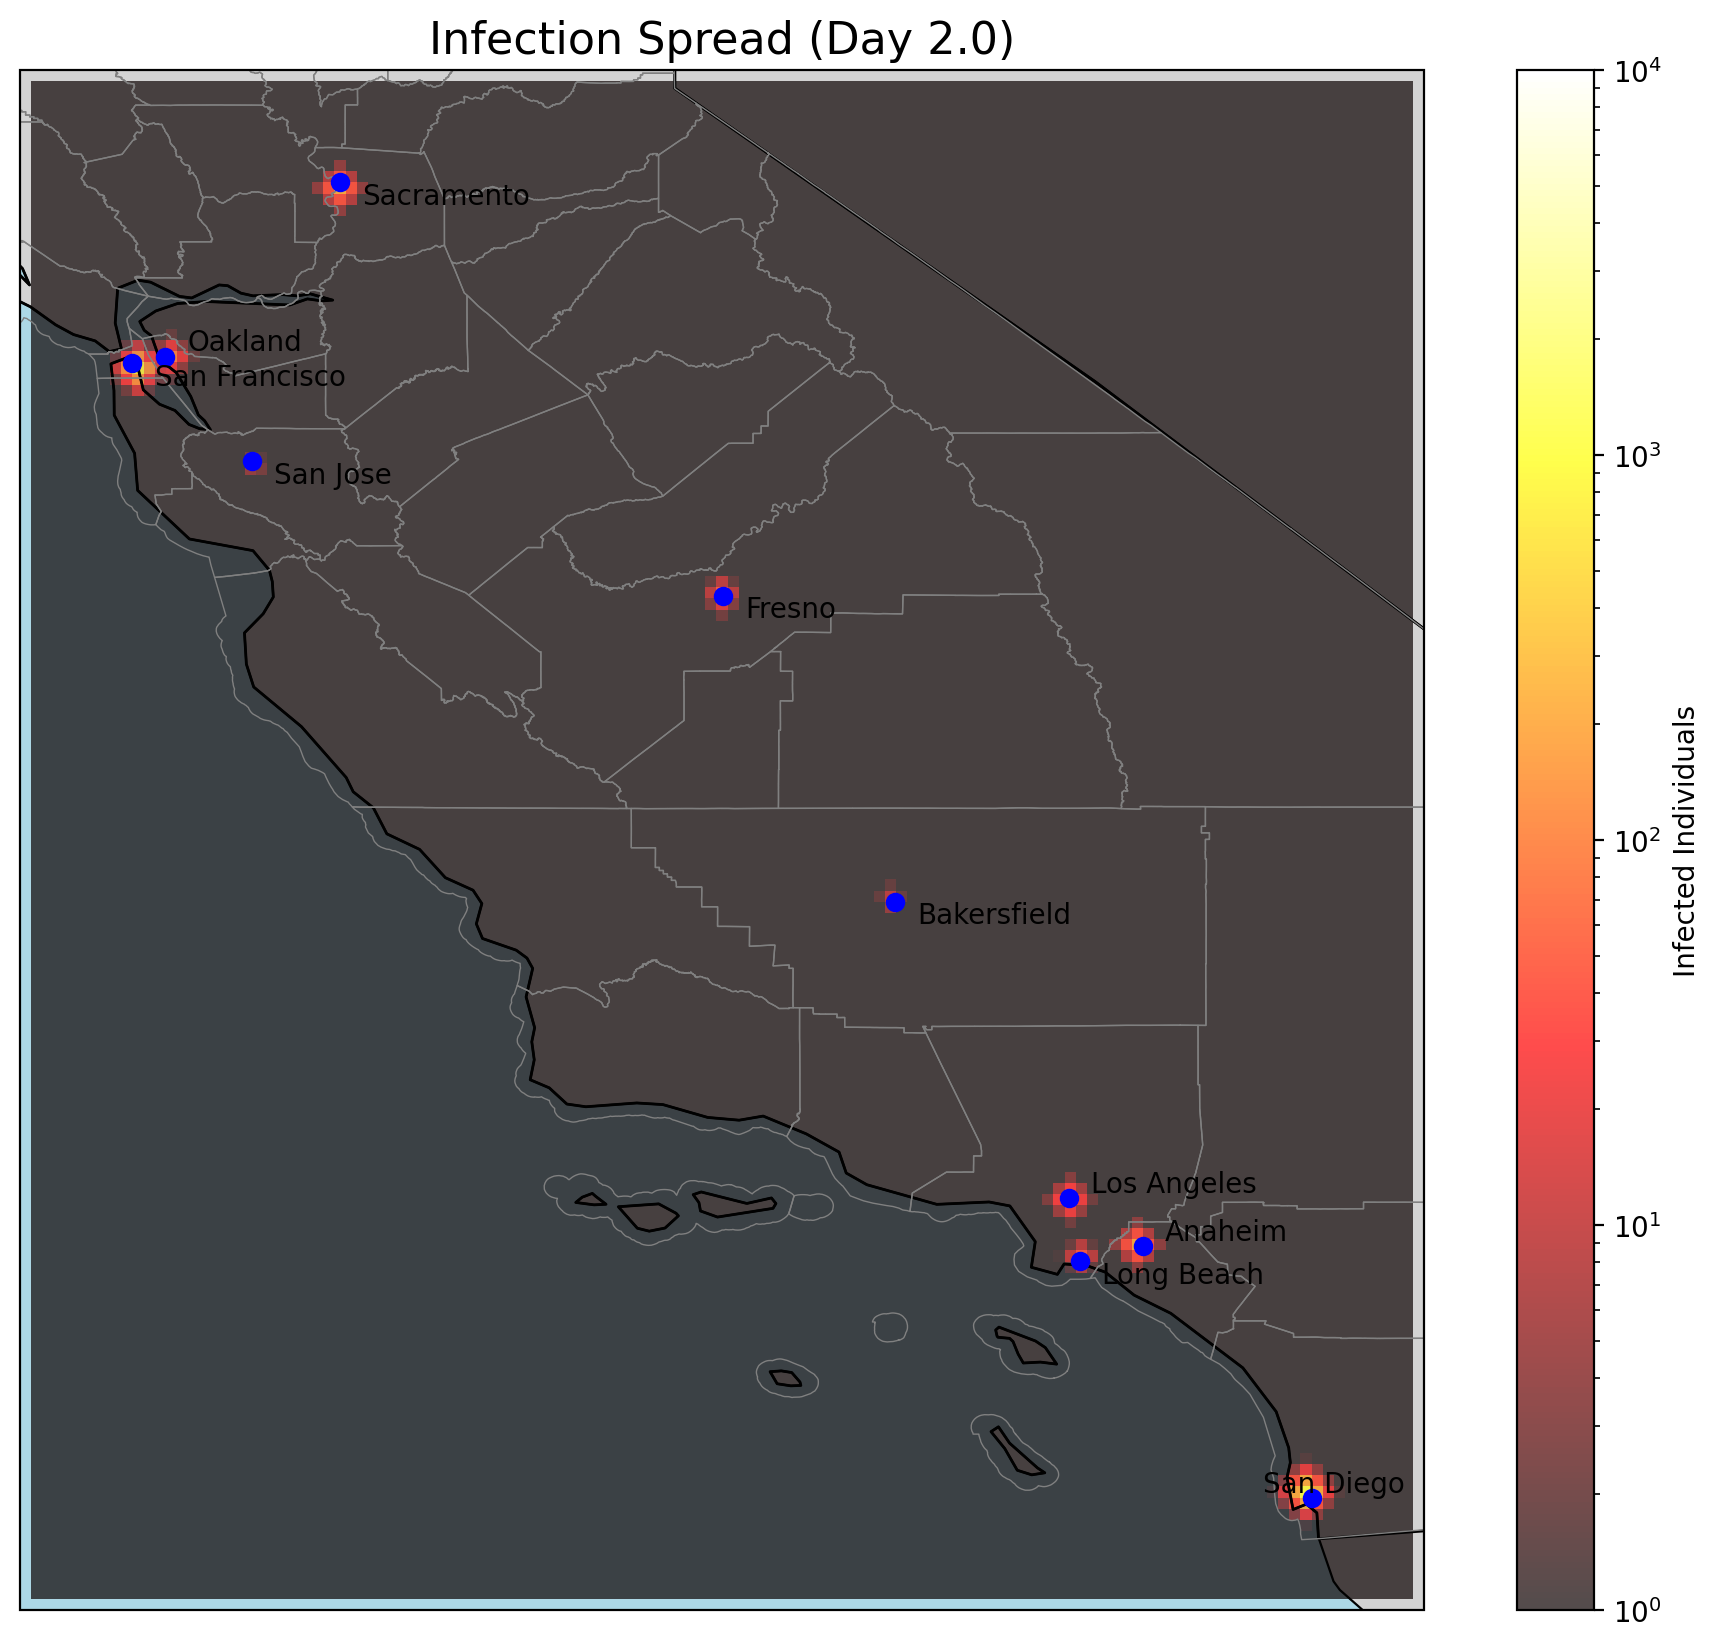

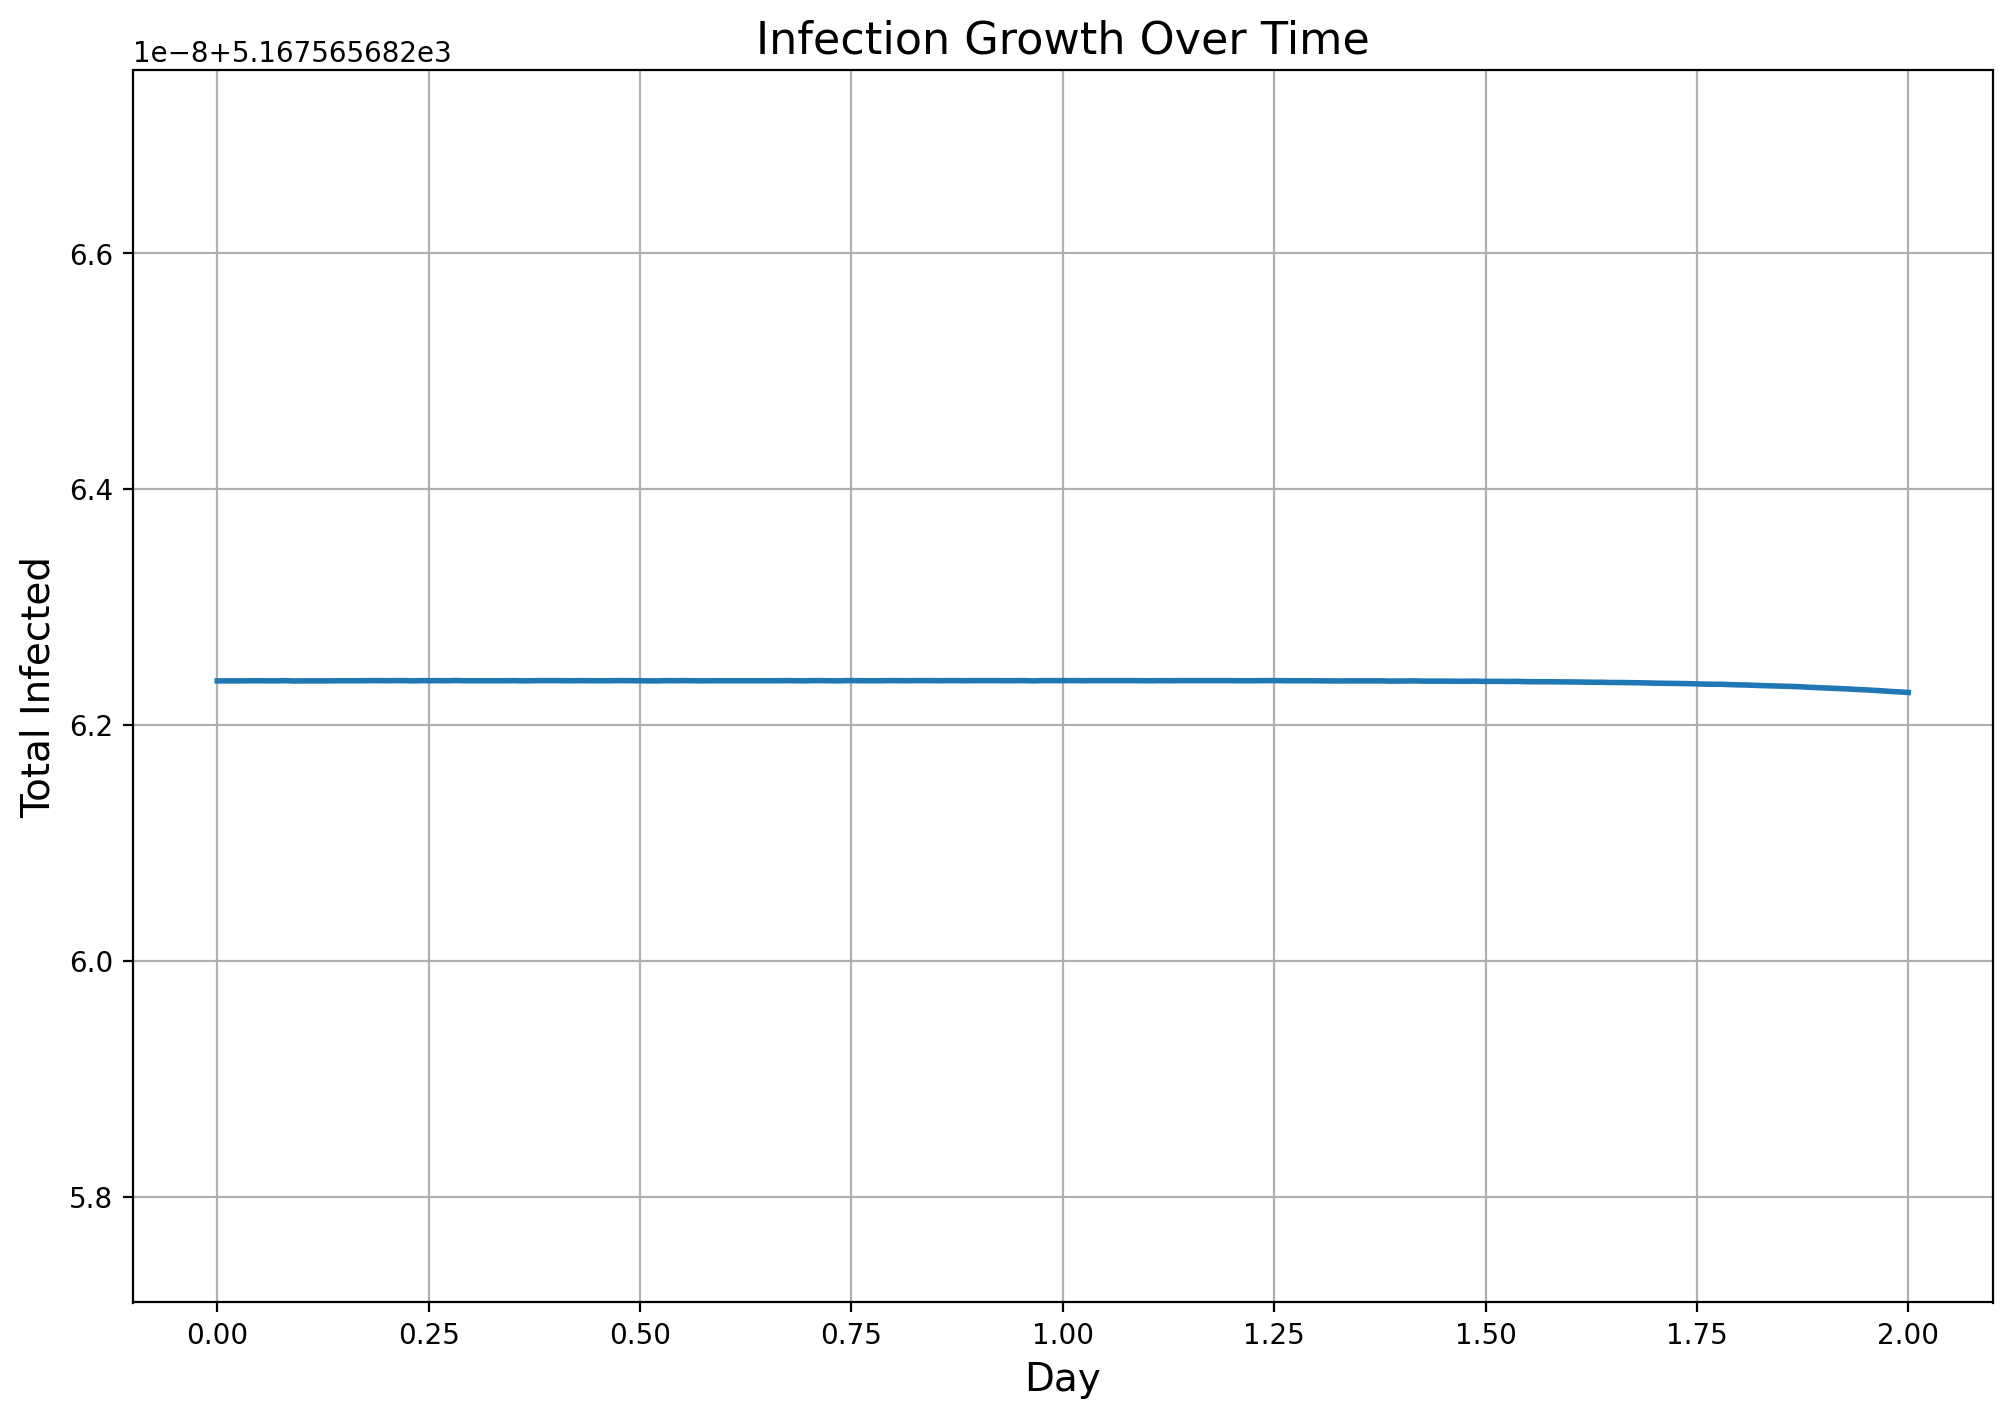

In [37]:
# -----------------------------
# 1. Define Basic Simulation Settings
# -----------------------------
grid_resolution = 20  # Points per degree

endDay = 2
dt = 0.01
diffusion_coefficient = 0.1
initial_infection_percentage = 0.002
sigma_deg = 0.01

# -----------------------------
# 2. Create Masks (land_mask, coastline_mask)
# -----------------------------
grid_width = int((max_lon - min_lon) * grid_resolution)
grid_height = int((max_lat - min_lat) * grid_resolution)

county_boundaries_mask, coastline_mask, land_mask = create_boundary_masks(
    grid_height, grid_width,
    min_lat, max_lat, min_lon, max_lon,
    counties=california_counties
)

# -----------------------------
# 3. Initialize Infection Grid
# -----------------------------
u = initialize_infection(
    california_cities, min_lat, max_lat, min_lon, max_lon,
    grid_resolution=grid_resolution,
    initial_infection_percentage=initial_infection_percentage,
    sigma_deg=sigma_deg,
    land_mask=land_mask
)

# -----------------------------
# 4. Run Simulation
# -----------------------------
u_final, infection_history, final_day = run_to_time(
    u_initial=u,
    target_day=endDay,
    diffusion_coefficient=diffusion_coefficient,
    dt=dt,
    coastline_mask=coastline_mask,
    land_mask=land_mask
)

# -----------------------------
# 5. Plot Infection Map
# -----------------------------
plot_infection_map(
    u=u_final,
    min_lat=min_lat, max_lat=max_lat,
    min_lon=min_lon, max_lon=max_lon,
    day=final_day,
    california_cities=california_cities,
    california_counties=california_counties,
    cmap='hot'
)

# -----------------------------
# 6. Plot Infection Growth
# -----------------------------
plot_infection_growth(
    history=infection_history,
    day=final_day
)
